Pixel scale: 0.334 kpc/pixel


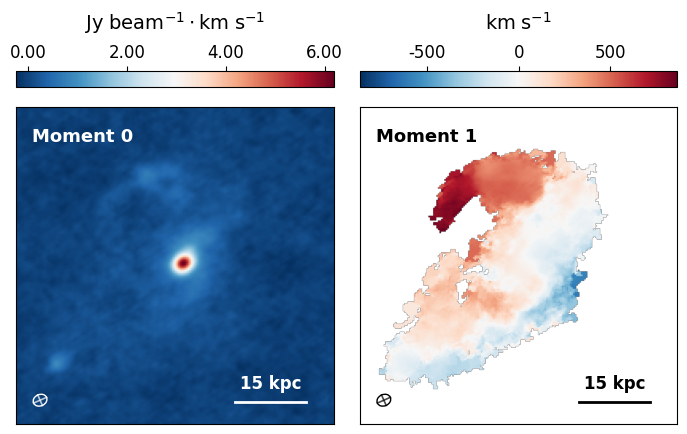

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.wcs import WCS
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astrodendro import Dendrogram
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import Planck18
from spectral_cube import SpectralCube
from astropy import units as u

# Load the cube
fname = '/Users/arnablahiry/Work/data/W2246/W2246_C2_125.fits'

cube = SpectralCube.read(fname)


# Define pixel slices: [start:stop] along each axis (z, y, x)
# Example: cropping the cube in all three dimensions


from spectral_cube import SpectralCube

# Define pixel slices (example: crop spatial axes only)
# Suppose cube shape is (velocity, y, x)
# Crop y from 200 to 400, x from 200 to 400, keep all velocity channels
slices = (slice(None), slice(200, 400), slice(200, 400))

# Crop the cube spatially
# Suppose you want to crop x pixels from 200 to 400, y pixels 200 to 400
cropped_cube = cube.subcube(xlo=195, xhi=395, ylo=200, yhi=400)

# The subcube preserves WCS and beam info automatically

# Save the cropped cube to a new FITS file
#cropped_cube.write('cropped_cube.fits', overwrite=True)

# Save if needed
#cropped_cube.write("/Users/arnablahiry/Work/data/W2246/CROPPED_ONLY_SPATIAL_W2246_CII_125.fits", overwrite=True)

header = cropped_cube.header

# --- Cosmology ---
z = 4.6
kpc_per_arcsec = Planck18.kpc_proper_per_arcmin(z).to('kpc/arcsec').value

# --- Pixel scale ---
pixscale_deg = abs(header['CDELT1'])             # deg/pixel
pixscale_arcsec = pixscale_deg * 3600            # arcsec/pixel
pixscale_kpc = pixscale_arcsec * kpc_per_arcsec  # kpc/pixel
print(f"Pixel scale: {pixscale_kpc:.3f} kpc/pixel")

# --- Get unitless moment-0 map ---
data = cropped_cube.unmasked_data[:]  # astropy Quantity (Jy/beam or Jy/pixel)
data = data.value             # strip units → plain numpy array



mask = np.zeros(data.shape, dtype=bool)
d1 = Dendrogram.compute(data, min_value=1.3 * data.std(), min_delta=3*data.std(), verbose=False)
for trunk in d1.trunk:
    mask |= trunk.get_mask()

    
hdul_real_data = fits.open(fname)

# Load beam table
beam_info = hdul_real_data[1]
beam_data = beam_info.data  # this is a structured array

# Extract each field and take the mean
bmaj = beam_data['BMAJ'].mean()/pixscale_arcsec  
bmin = beam_data['BMIN'].mean()/pixscale_arcsec   
bpa  = beam_data['BPA'].mean()  


import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import importlib
import functions
importlib.reload(functions)
from functions import *


# Get image shape and extent in kpc
ny, nx = data.shape[1], data.shape[2]
x_max = nx# * pix_spatial_scale
y_max = ny# * pix_spatial_scale
extent = [0, x_max, 0, y_max]  # (xmin, xmax, ymin, ymax)

# Define tick locations (in kpc)
num_ticks = 5
tick_locs = np.linspace(0, x_max, num_ticks)
tick_labels = [f"{tick:.1f}" for tick in tick_locs]


# Sum the flux over all pixels (spatially integrated spectrum)
integrated_spectrum = cube.filled_data[:].sum(axis=(1, 2))  # Sum over the x and y axes


rest_freq = cube.header['RESTFRQ'] * u.Hz  # For example, if this is in the header

# Get the original frequency axis (in Hz)
frequency_axis = cube.spectral_axis

# Convert the frequency axis to velocity (km/s)
velocity_axis = frequency_axis.to(u.km / u.s, equivalencies=u.doppler_radio(rest_freq)).value

cdelt = velocity_axis[1]-velocity_axis[0]
moment_cube = data * velocity_axis[:, np.newaxis, np.newaxis]  # Calculate the moment cube



fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharex=True, sharey=True)

# Plot 1: moment 0 map
im0 = ax[0].imshow(data.sum(axis=0)*cdelt, cmap='RdBu_r', origin='lower', extent=extent)
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("top", size="5%", pad=0.2)
cb0 = fig.colorbar(im0, cax=cax0, orientation='horizontal', format='%.2f')
cb0.set_label(r'$\rm Jy\;beam^{-1}\cdot km\;s^{-1}$', rotation=0, labelpad=10, fontsize=15)
cb0.ax.xaxis.set_label_position('top')
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.label.set_size(14)
cb0.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb0.ax.xaxis.labelpad = 10
ax[0].text(x_max * 0.05, y_max * 0.89, 'Moment 0', color='white', fontsize=13, weight='bold')
add_beam(ax[0], bmin, bmaj, 90+bpa, xy_offset=(15, 15), color='white')




# Plot 2: moment 1 map
numerator = (mask * moment_cube).sum(axis=0)
denominator = (mask * data).sum(axis=0)
ratio = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator != 0)
max = np.max([np.abs(np.nanmin(ratio)), np.abs(np.nanmax(ratio))])
im1 = ax[1].imshow(ratio, cmap='RdBu_r', origin='lower', extent=extent, vmin=-max, vmax=max)
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("top", size="5%", pad=0.2)
cb1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', format='%.0f')
cb1.set_label(r'$\rm km\;s^{-1}$', rotation=0, labelpad=10, fontsize=15)
cb1.ax.xaxis.set_label_position('top')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb1.ax.xaxis.label.set_size(14)
cb1.ax.xaxis.labelpad = 10
ax[1].text(x_max * 0.05, y_max * 0.89, 'Moment 1', color='black', fontsize=13, weight='bold')
add_beam(ax[1], bmin, bmaj, 90+bpa, xy_offset=(15, 15), color='black')

# Remove ticks and labels
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel('')
    a.set_ylabel('')

# Add scalebars
kpc = 15
scalebar_length = kpc/pixscale_kpc  # in kpc
x0 = x_max * 0.69
y0 = y_max * 0.07

# Scalebar for Moment 0
ax[0].plot([x0, x0 + scalebar_length], [y0, y0], color='white', lw=2)
ax[0].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{kpc} kpc',
           color='white', ha='center', va='bottom', fontsize=12, weight='bold')

# Scalebar for Moment 1
ax[1].plot([x0, x0 + scalebar_length], [y0, y0], color='black', lw=2)
ax[1].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{kpc} kpc',
           color='black', ha='center', va='bottom', fontsize=12, weight='bold')


for a in ax:
    a.set_aspect('equal')  # or 'auto' if stretching is preferred


plt.tight_layout()
plt.savefig('figures/moment_maps_w2246.pdf', bbox_inches='tight')
plt.show()

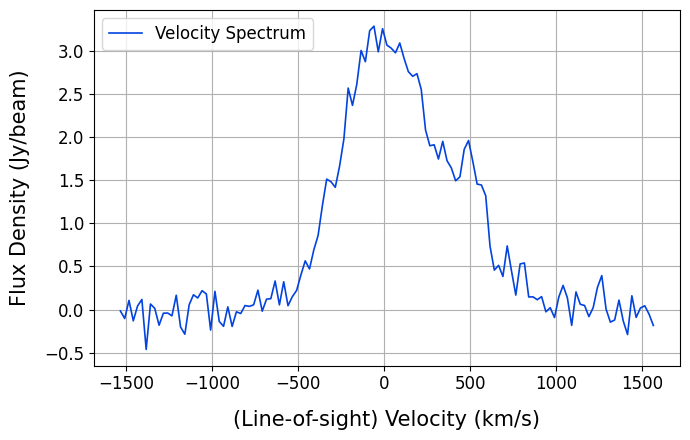

In [4]:
plt.figure(figsize = (7, 4.5))
#plt.plot(vels, np.sum(convolved_cube, axis=(1,2)), color='xkcd:blue', label='Velocity Spectrum', linewidth=0.8, alpha=0.3)
from scipy.ndimage import gaussian_filter1d
y_smooth = np.sum(data, axis=(1,2))
plt.plot(velocity_axis, y_smooth, color='xkcd:blue', label='Velocity Spectrum', linewidth=1.2)
plt.ylabel('Flux Density (Jy/beam)', fontsize=15, labelpad = 10)
plt.xlabel('(Line-of-sight) Velocity (km/s)', fontsize=15, labelpad = 12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True)
plt.legend(fontsize = 12, loc='upper left')
plt.tight_layout()
plt.savefig('figures/init_velocity_spectrum_w2246.pdf', bbox_inches='tight')
plt.show()

In [220]:
import matplotlib.pyplot as plt

# Example: assume these are provided
# cube: a 3D numpy array with shape (z, y, x)
# convolve_beam(cube, beam_width): returns a convolved 3D cube
# apply_noise(cube, peak_snr): returns a noisy 3D cube

def plot_beam_noise_grid(cube, beam_widths, peak_snrs, slice_idx=0, cmap='inferno'):
    n_rows = len(peak_snrs)
    n_cols = len(beam_widths)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

    for col, beam_width in enumerate(beam_widths):
        # Convolve once per column
        convolved_cube = convolve_beam(cube, beam_width)
        for row, peak_snr in enumerate(peak_snrs):
            # Apply noise for each row (on already convolved cube)
            noisy_cube = apply_noise(convolved_cube, peak_snr)
            ax = axes[row, col] if n_rows > 1 and n_cols > 1 else axes[max(row, col)]
            ax.imshow(noisy_cube[slice_idx], origin='lower', cmap=cmap)
            ax.axis('off')
            if row == 0:
                ax.set_title(f'Beam: {beam_width}', fontsize=10)
            if col == 0:
                ax.set_ylabel(f'SNR: {peak_snr}', fontsize=10)

    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.wcs import WCS
from astropy.io import fits
from spectral_cube import SpectralCube

# Load the FITS file using Astropy
fits_file = '/Users/arnablahiry/Work/data/W2246/CROPPED_ONLY_SPATIAL_W2246_CII_314.fits'
hdul = fits.open(fits_file)

# Extract data and WCS
cube_data = hdul[0].data
wcs = WCS(hdul[0].header)
cube_array = np.asarray(cube_data)


# Get pixel scale (assuming CDELT1 and CDELT2 are present)

# Convert beam size from degrees to pixels
bmaj_pixels = bmaj / pix_scale  # Convert major axis to pixels
bmin_pixels = bmin / pix_scale  # Convert minor axis to pixels

# Find the voxel with the maximum value
max_voxel_index = np.argmax(cube_array)
max_channel, max_y, max_x = np.unravel_index(max_voxel_index, cube_array.shape)

# Slice the WCS to 2D celestial (RA-Dec) projection
wcs_slice = wcs.celestial






# Create the figure and subplots
fig = plt.figure(figsize=(13.5, 5.1))









# Left plot: WCS image
ax0 = fig.add_subplot(1, 2, 1, projection=wcs_slice)
im0 = ax0.imshow(cube_array[max_channel], origin='lower', cmap='RdBu_r')
fig.colorbar(im0, ax=ax0)




corner_offset = 7
beam_center = (corner_offset + bmaj_pixels / 2, corner_offset + bmin_pixels / 2)

# Create an ellipse patch
beam_ellipse = patches.Ellipse(
    xy=beam_center, width=bmaj_pixels, height=bmin_pixels,
    angle=90+bpa, edgecolor="white", facecolor="none", linestyle='-', linewidth=1
)

ax0.add_patch(beam_ellipse)


print(bmaj_pixels, bmin_pixels)

ax0.text(
    beam_center[0] + (2 * bmaj_pixels) / 1.5 + 8.5, 6 , "Beam",
    color="white", fontsize=12, ha="center", va="bottom", bbox=dict(facecolor="black", alpha=0.0, edgecolor="none")
)




# Format axes in degrees
ax0.coords[0].set_format_unit('deg')
ax0.coords[1].set_format_unit('deg')
# Turn off top and right axes in WCSAxes
ax0.coords['ra'].set_ticks_position('bl')  # Show ticks only on bottom
ax0.coords['dec'].set_ticks_position('l')  # Show ticks only on left

# Remove default WCS axis label (not matplotlib's)
ax0.coords[1].set_axislabel(' ')  # Declination
ax0.coords[0].set_axislabel(' ')  # Remove the default label
ax0.text(0.5, -0.1, 'Right Ascension', fontsize=15,
         transform=ax0.transAxes, ha='center', va='top')

# Add custom ylabel manually in axes coordinates
ax0.text(-0.13, 0.5, 'Declination', fontsize=15,
         transform=ax0.transAxes, rotation='vertical',
         va='center', ha='right')

ax0.tick_params(axis='both', labelsize=11)


# Right plot: Spectrum
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(velocity_axis, integrated_spectrum.value, color='xkcd:blue', label='Velocity Spectrum')
ax1.set_ylabel('Flux Density (Jy/beam)', fontsize=15, labelpad = 10)
ax1.set_xlabel('LOS Velocity (km/s)', fontsize=15, labelpad = 12)
ax1.tick_params(axis='x', labelsize=13)

ax1.grid(True)

from matplotlib.ticker import FuncFormatter

ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1f}'))

plt.legend(fontsize = 13)

# Finalize
plt.tight_layout()
plt.savefig('w2246_spectra.pdf', bbox_inches = 'tight')
plt.show()

# Close FITS
hdul.close()


In [ ]:
plt.imshow(cube_data[157], origin = 'lower')

In [ ]:
print(np.max(cube_data))

print(np.std(cube_data[:,0:50, 150:200]))

print(np.max(cube_data) / np.std(cube_data[:,0:50, 150:200]))

In [ ]:


# Draw the beam as an ellipse
corner_offset = 7
beam_width_px = 0.2 / (0.06*(64/200))
beam_center = (corner_offset + beam_width_px / 2, corner_offset + beam_width_px / 2)

beam_ellipse = patches.Ellipse(
    xy=beam_center, width=beam_width_px, height=beam_width_px, label='Beam',
    angle=0, edgecolor="white", facecolor="none", linestyle='-', linewidth=1
)

ax[0].add_patch(beam_ellipse)

# Add text for the beam
ax[0].text(
    beam_center[0] + (2 * beam_width_px) / 1.5 + 7.5, corner_offset + 0.8, "Beam",
    color="white", fontsize=12, ha="center", va="bottom", bbox=dict(facecolor="black", alpha=0.0, edgecolor="none")
)

# Title and label for the first subplot
ax[0].text(0.05, 0.95, r'$W2246$' + ' ALMA Cube', transform=ax[0].transAxes, color='white', fontsize=13, ha='left', va='top', 
        bbox=dict(facecolor='midnightblue', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.0))


In [44]:
(6/(5*3.75/2))*72

46.08

In [43]:
8*72

576

1168
[3. 3.] 3.75
[5.625 5.625]

[ § Creating 2 highly resolved cubes of dimensions 36 (spectral) x 72 x 72 (spatial) § ]

[0.5 0.5] 3.75
[0.9375 0.9375]

[ § Creating 2 highly resolved cubes of dimensions 36 (spectral) x 72 x 72 (spatial) § ]

Time taken: 7.463406085968018 seconds
3.388888888888889
0.8888888888888888
23


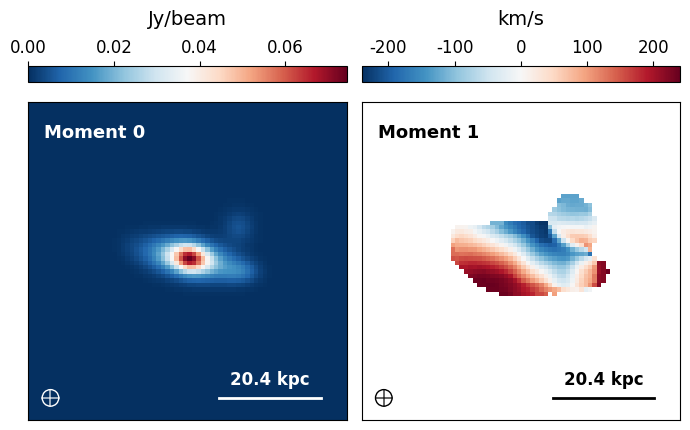

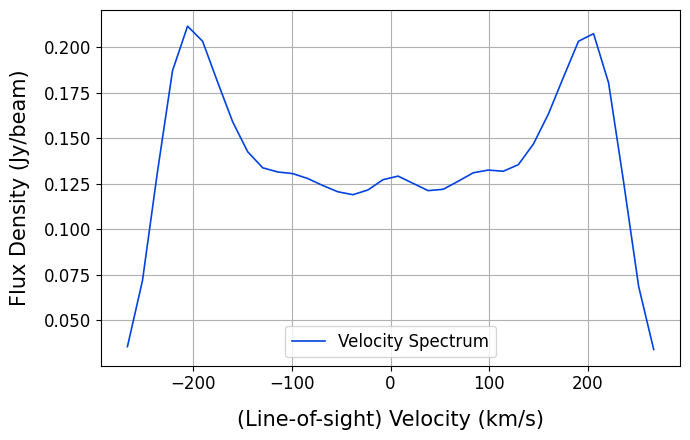

7.833333333333333


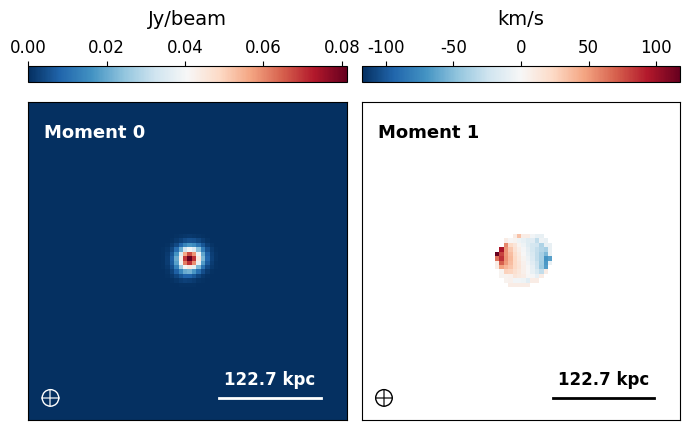

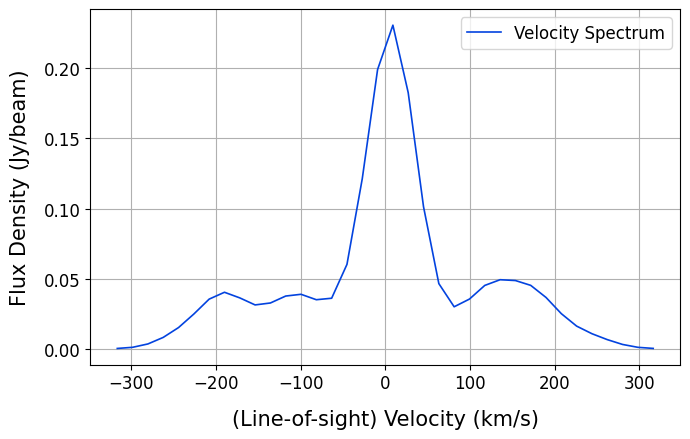

In [39]:
import toy_cube_dataset
import importlib
importlib.reload(toy_cube_dataset)
from toy_cube_dataset import *
import time

start = time.time()
n_gals = 3
offset_gals = 15
n_cubes = 2
init_grid_size= 31
final_grid_size=72
n_spectral_slices=36
beam_size = 5*(final_grid_size/96)


seed = np.random.randint(0, 10000)
case1 = 'resolved'
case2 = 'unresolved'
print(seed)

fname = f'/Users/arnablahiry/Work/data/toy_cubes/datasets/'

resolved_dataset = ResolvedSpectralCubeDataset(n_gals = n_gals, resolution=case1,offset_gals=offset_gals, beam_size=beam_size,
                                               n_cubes=n_cubes, init_grid_size= init_grid_size, final_grid_size=final_grid_size,
                                               n_spectral_slices=n_spectral_slices, verbose=False, plot=False, seed=seed)

unresolved_dataset = ResolvedSpectralCubeDataset(n_gals = n_gals, resolution=case2,offset_gals=offset_gals, beam_size=beam_size,
                                               n_cubes=n_cubes, init_grid_size= init_grid_size, final_grid_size=final_grid_size,
                                               n_spectral_slices=n_spectral_slices, verbose=False, plot=False, seed=seed)


stop = time.time()
print(f'Time taken: {stop - start} seconds')    


case = 'resolved'

from astrodendro import Dendrogram
cube = resolved_dataset[0][0]
print(resolved_dataset[0][1]['redshift'])
convolved_cube = convolve_beam(cube,5*(final_grid_size/96))

vels = resolved_dataset[0][1]['average_vels']
pix_spatial_scale = resolved_dataset[0][1]['pix_spatial_scale']
moment_cube = convolved_cube * vels[:, np.newaxis, np.newaxis]  # Calculate the moment cube

print(pix_spatial_scale)


mask = np.zeros(convolved_cube.shape, dtype=bool)
d1 = Dendrogram.compute(convolved_cube, min_value=0.25 * convolved_cube.std(), min_delta=convolved_cube.std(), verbose=False)
for trunk in d1.trunk:
    mask |= trunk.get_mask()


import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get image shape and extent in kpc
ny, nx = cube.shape[1], cube.shape[2]
x_max = nx# * pix_spatial_scale
y_max = ny# * pix_spatial_scale
extent = [0, x_max, 0, y_max]  # (xmin, xmax, ymin, ymax)

# Define tick locations (in kpc)
num_ticks = 5
tick_locs = np.linspace(0, x_max, num_ticks)
tick_labels = [f"{tick:.1f}" for tick in tick_locs]

fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharex=True, sharey=True)

# Plot 1: moment 0 map
im0 = ax[0].imshow(convolved_cube.sum(axis=0), cmap='RdBu_r', origin='lower', extent=extent)
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("top", size="5%", pad=0.2)
cb0 = fig.colorbar(im0, cax=cax0, orientation='horizontal', label='Jy/beam', format='%.2f')
cb0.ax.xaxis.set_label_position('top')
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.label.set_size(14)
cb0.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb0.ax.xaxis.labelpad = 10
ax[0].text(x_max * 0.05, y_max * 0.89, 'Moment 0', color='white', fontsize=13, weight='bold')
add_beam(ax[0], 3.75, 3.75, 0, xy_offset=(5, 5), color='white')

# Plot 2: moment 1 map
numerator = (mask * moment_cube).sum(axis=0)
denominator = (mask * convolved_cube).sum(axis=0)
ratio = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator != 0)
max = np.max([np.abs(np.nanmin(ratio)), np.abs(np.nanmax(ratio))])
im1 = ax[1].imshow(ratio, cmap='RdBu_r', origin='lower', extent=extent, vmin=-max, vmax=max)
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("top", size="5%", pad=0.2)
cb1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', label='km/s', format='%.0f')
cb1.ax.xaxis.set_label_position('top')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb1.ax.xaxis.label.set_size(14)
cb1.ax.xaxis.labelpad = 10
ax[1].text(x_max * 0.05, y_max * 0.89, 'Moment 1', color='black', fontsize=13, weight='bold')
add_beam(ax[1], 3.75, 3.75, 0, xy_offset=(5, 5), color='black')

# Remove ticks and labels
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel('')
    a.set_ylabel('')

# Add scalebars
scalebar_length = 23 #kpc/pix_spatial_scale  # in kpc
print(scalebar_length)
x0 = x_max * 0.6
y0 = y_max * 0.07

# Scalebar for Moment 0
ax[0].plot([x0, x0 + scalebar_length], [y0, y0], color='white', lw=2)
ax[0].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{23*pix_spatial_scale:.1f} kpc',
           color='white', ha='center', va='bottom', fontsize=12, weight='bold')

# Scalebar for Moment 1
ax[1].plot([x0, x0 + scalebar_length], [y0, y0], color='black', lw=2)
ax[1].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{23*pix_spatial_scale:.1f} kpc',
           color='black', ha='center', va='bottom', fontsize=12, weight='bold')


for a in ax:
    a.set_aspect('equal')  # or 'auto' if stretching is preferred


plt.tight_layout()
plt.savefig('moment_maps_res.pdf', bbox_inches='tight')
plt.show()


plt.figure(figsize = (7, 4.5))
from scipy.ndimage import gaussian_filter1d
y_smooth = gaussian_filter1d(np.sum(convolved_cube, axis=(1,2)), sigma=1.5)
plt.plot(vels, y_smooth, color='xkcd:blue', label='Velocity Spectrum', linewidth=1.2)
plt.ylabel('Flux Density (Jy/beam)', fontsize=15, labelpad = 10)
plt.xlabel('(Line-of-sight) Velocity (km/s)', fontsize=15, labelpad = 12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True)
plt.legend(fontsize = 12, loc='lower center')
plt.tight_layout()
plt.savefig('init_velocity_spectrum_res.pdf', bbox_inches='tight')
plt.show()



case = 'unresolved'

from astrodendro import Dendrogram
cube = unresolved_dataset[0][0]
print(unresolved_dataset[0][1]['redshift'])
convolved_cube = convolve_beam(cube,3.75)
vels = unresolved_dataset[0][1]['average_vels']
pix_spatial_scale = unresolved_dataset[0][1]['pix_spatial_scale']
moment_cube = convolved_cube * vels[:, np.newaxis, np.newaxis]  # Calculate the moment cube


if case == 'resolved':
    kpc = 30
elif case == 'unresolved':
    kpc = 110

mask = np.zeros(convolved_cube.shape, dtype=bool)
d1 = Dendrogram.compute(convolved_cube, min_value=0.25 * convolved_cube.std(), min_delta=convolved_cube.std(), verbose=False)
for trunk in d1.trunk:
    mask |= trunk.get_mask()


import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get image shape and extent in kpc
ny, nx = cube.shape[1], cube.shape[2]
x_max = nx# * pix_spatial_scale
y_max = ny# * pix_spatial_scale
extent = [0, x_max, 0, y_max]  # (xmin, xmax, ymin, ymax)

# Define tick locations (in kpc)
num_ticks = 5
tick_locs = np.linspace(0, x_max, num_ticks)
tick_labels = [f"{tick:.1f}" for tick in tick_locs]

fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharex=True, sharey=True)

# Plot 1: moment 0 map
im0 = ax[0].imshow(convolved_cube.sum(axis=0), cmap='RdBu_r', origin='lower', extent=extent)
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("top", size="5%", pad=0.2)
cb0 = fig.colorbar(im0, cax=cax0, orientation='horizontal', label='Jy/beam', format='%.2f')
cb0.ax.xaxis.set_label_position('top')
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.label.set_size(14)
cb0.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb0.ax.xaxis.labelpad = 10
ax[0].text(x_max * 0.05, y_max * 0.89, 'Moment 0', color='white', fontsize=13, weight='bold')
add_beam(ax[0], 3.75, 3.75, 0, xy_offset=(5, 5), color='white')

# Plot 2: moment 1 map
numerator = (mask * moment_cube).sum(axis=0)
denominator = (mask * convolved_cube).sum(axis=0)
ratio = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator != 0)
max = np.max([np.abs(np.nanmin(ratio)), np.abs(np.nanmax(ratio))])
im1 = ax[1].imshow(ratio, cmap='RdBu_r', origin='lower', extent=extent, vmin=-max, vmax=max)
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("top", size="5%", pad=0.2)
cb1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', label='km/s', format='%.0f')
cb1.ax.xaxis.set_label_position('top')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb1.ax.xaxis.label.set_size(14)
cb1.ax.xaxis.labelpad = 10
ax[1].text(x_max * 0.05, y_max * 0.89, 'Moment 1', color='black', fontsize=13, weight='bold')
add_beam(ax[1], 3.75, 3.75, 0, xy_offset=(5, 5), color='black')

# Remove ticks and labels
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel('')
    a.set_ylabel('')

# Add scalebars
scalebar_length = 23  # in kpc
x0 = x_max * 0.6
y0 = y_max * 0.07

# Scalebar for Moment 0
ax[0].plot([x0, x0 + scalebar_length], [y0, y0], color='white', lw=2)
ax[0].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{scalebar_length*pix_spatial_scale:.1f} kpc',
           color='white', ha='center', va='bottom', fontsize=12, weight='bold')

# Scalebar for Moment 1
ax[1].plot([x0, x0 + scalebar_length], [y0, y0], color='black', lw=2)
ax[1].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{scalebar_length*pix_spatial_scale:.1f} kpc',
           color='black', ha='center', va='bottom', fontsize=12, weight='bold')


for a in ax:
    a.set_aspect('equal')  # or 'auto' if stretching is preferred


plt.tight_layout()
plt.savefig('moment_maps_unres.pdf', bbox_inches='tight')
plt.show()


plt.figure(figsize = (7, 4.5))
#plt.plot(vels, np.sum(convolved_cube, axis=(1,2)), color='xkcd:blue', label='Velocity Spectrum', linewidth=0.8, alpha=0.3)
from scipy.ndimage import gaussian_filter1d
y_smooth = gaussian_filter1d(np.sum(convolved_cube, axis=(1,2)), sigma=1.5)
plt.plot(vels, y_smooth, color='xkcd:blue', label='Velocity Spectrum', linewidth=1.2)
plt.ylabel('Flux Density (Jy/beam)', fontsize=15, labelpad = 10)
plt.xlabel('(Line-of-sight) Velocity (km/s)', fontsize=15, labelpad = 12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True)
plt.legend(fontsize = 12, loc='upper right')
plt.tight_layout()
plt.savefig('init_velocity_spectrum_unres.pdf', bbox_inches='tight')
plt.show()


In [35]:
print(resolved_dataset[0][1]['pix_spatial_scale'])
print(unresolved_dataset[0][1]['pix_spatial_scale'])

1.5000000000000002
6.000000000000001


In [31]:
resolved_convolved = convolve_beam(resolved_dataset[0][0], 3.75)
unresolved_convolved = convolve_beam(unresolved_dataset[0][0], 3.75)

np.save('resolved_cube.npy', resolved_convolved)
np.save('unresolved_cube.npy', unresolved_convolved)

np.save('resolved_vels.npy', resolved_dataset[0][1]['average_vels'])
np.save('unresolved_vels.npy', unresolved_dataset[0][1]['average_vels'])

In [28]:
import pycs

In [ ]:
import numpy as np
from matplotlib import gridspec
from matplotlib.lines import Line2D
from u_net_model import *
from wavelet_denoising import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pysparse

mean_dataset, std_dataset = 1.5502414918156043e-06, 0.0001832498356025477

peak_snrs = [3, 6, 10]
labels = [r'2D1D-IST-5$\sigma$', 'U-Net3D-64', 'Noisy', 'Ground Truth']

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey='row', sharex='col')
lines = []


device = torch.device('cpu')

# Define model

base_model = UNet3D(n_channels=1, filters=16)
model = UNet3DWithPadCrop(base_model, target_shape=(48, 80, 80)).to(device)
fweights_best = '/home/alahiry/deep_learning/denoise_comparison/final/x72_n20000_64_filters_batch_16/weights_best.pt'

if os.path.exists(fweights_best):
    model.load_state_dict(torch.load(fweights_best, map_location=device, weights_only=True))
    print("\nModel and weights loaded!")
else:
    raise FileNotFoundError(f"Model weights not found at {fweights_best}.")

model.eval()


# Top row: Resolved Sources (idx=100)
idx = 100
clean_cube = resolved_convolved * std_dataset + mean_dataset
vels = resolved_dataset[0][0]['average_vels']
mask = create_circular_aperture_mask(clean_cube, 5/resolved_dataset[0][0]['pix_spatial_scale'], 3.75)
for i, peak_snr in enumerate(peak_snrs):
    noisy_cube = apply_and_convolve_noise(clean_cube, peak_snr, 0.2)
    denoiser3d_soft = Denoiser2D1D(threshold_type='soft', verbose=False, plot=False)
    denosied_cube_ist, *_ = denoiser3d_soft(
        noisy_cube, clean_cube, threshold_level=5, method='iterative', emission_mask=mask,
        num_iter_reweight=100, num_iter_debias=100, num_scales_2d=None, num_scales_1d=None, noise_cube=None
    )
    obvs_unet_input = torch.tensor(np.expand_dims(np.expand_dims((noisy_cube-mean_dataset)/std_dataset, axis=0), axis=0), dtype=torch.float32)
    denosied_cube_unet = model(obvs_unet_input).detach().numpy()[0, 0, :, :] * std_dataset + mean_dataset

    ax = axes[0, i]
    l0, = ax.plot(vels, np.sum(mask*denosied_cube_ist, axis=(1,2)), color='xkcd:blue', label=labels[0])
    l1, = ax.plot(vels, np.sum(mask*denosied_cube_unet, axis=(1,2)), color='xkcd:red', label=labels[1])
    l2, = ax.plot(vels, np.sum(mask*noisy_cube, axis=(1,2)), linestyle='dotted', color='grey', label=labels[2], alpha=0.9)
    l3, = ax.plot(vels, np.sum(mask*clean_cube, axis=(1,2)), color='green', label=labels[3], alpha=1, linestyle='--')
    if i == 0:
        lines = [l0, l1, l2, l3]
        ax.set_ylabel('Aperture Flux', fontsize =12, labelpad=10)
    ax.grid(True)
    #ax.text(0.35, 0.9, f'Peak SNR = {peak_snr}', transform=ax.transAxes, fontsize=11, color='black',
            #bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round,pad=0.5'))
    ax.set_title(f'Peak SNR = {peak_snr}',pad=18, bbox=dict(facecolor='white', edgecolor='silver', boxstyle='round,pad=0.5'))

# Bottom row: Unresolved Sources (idx=900)
idx = 900
clean_cube = test_dataset[idx][1][0].detach().numpy() * std_dataset + mean_dataset
vels = test_dataset[idx][3]
mask = create_circular_aperture_mask(clean_cube, dataset[idx][2][1].item())
for i, peak_snr in enumerate(peak_snrs):
    noisy_cube = apply_and_convolve_noise(clean_cube, peak_snr, 0.2)
    denoiser3d_soft = Denoiser2D1D(threshold_type='soft', verbose=False, plot=False)
    denosied_cube_ist, *_ = denoiser3d_soft(
        noisy_cube, clean_cube, threshold_level=5, method='iterative', emission_mask=mask,
        num_iter_reweight=100, num_iter_debias=100, num_scales_2d=None, num_scales_1d=None, noise_cube=None
    )
    obvs_unet_input = torch.tensor(np.expand_dims(np.expand_dims((noisy_cube-mean_dataset)/std_dataset, axis=0), axis=0), dtype=torch.float32)
    denosied_cube_unet = model(obvs_unet_input).detach().numpy()[0, 0, :, :] * std_dataset + mean_dataset

    ax = axes[1, i]
    ax.plot(vels, np.sum(mask*denosied_cube_ist, axis=(1,2)), color='xkcd:blue', label=labels[0])
    ax.plot(vels, np.sum(mask*denosied_cube_unet, axis=(1,2)), color='xkcd:red', label=labels[1])
    ax.plot(vels, np.sum(mask*noisy_cube, axis=(1,2)), linestyle='dotted', color='grey', label=labels[2], alpha=0.9)
    ax.plot(vels, np.sum(mask*clean_cube, axis=(1,2)), color='green', label=labels[3], alpha=1, linestyle='--')
    if i == 0:
        ax.set_ylabel('Aperture Flux', fontsize =12, labelpad=10)
    ax.set_xlabel('LOS Velocity (km/s)', fontsize=12, labelpad=10)
    ax.grid(True)
    #ax.text(0.35, 0.9, f'Peak SNR = {peak_snr}', transform=ax.transAxes, fontsize=11, color='black',
            #bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round,pad=0.5'))

# Add bold group labels on the right
fig.text(0.92, 0.75, 'Resolved Source', va='center', rotation=270, fontsize=13, fontstyle='italic', bbox=dict(facecolor='white', edgecolor='silver', boxstyle='round,pad=0.5'))
fig.text(0.92, 0.32, 'Unresolved Source', va='center', rotation=270, fontsize=13, fontstyle='italic', bbox=dict(facecolor='white', edgecolor='silver', boxstyle='round,pad=0.5'))

# Legend below the figure
fig.legend(lines, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02), fontsize=12, frameon=False)

plt.tight_layout(rect=[0, 0.03, 0.91, 0.97])  # Leave space for right-side labels
plt.savefig('/home/alahiry/codes/denoise_comparison/figures/resolved_unresolved_spectra_comparison_multiSNR.pdf', bbox_inches='tight')
plt.show()


ModuleNotFoundError: No module named 'pysparse'

6203
[ 0.6  2.4  4.   6.  10. ]

[ § Creating 5 highly resolved cubes of dimensions 40 (spectral) x 96 x 96 (spatial) § ]



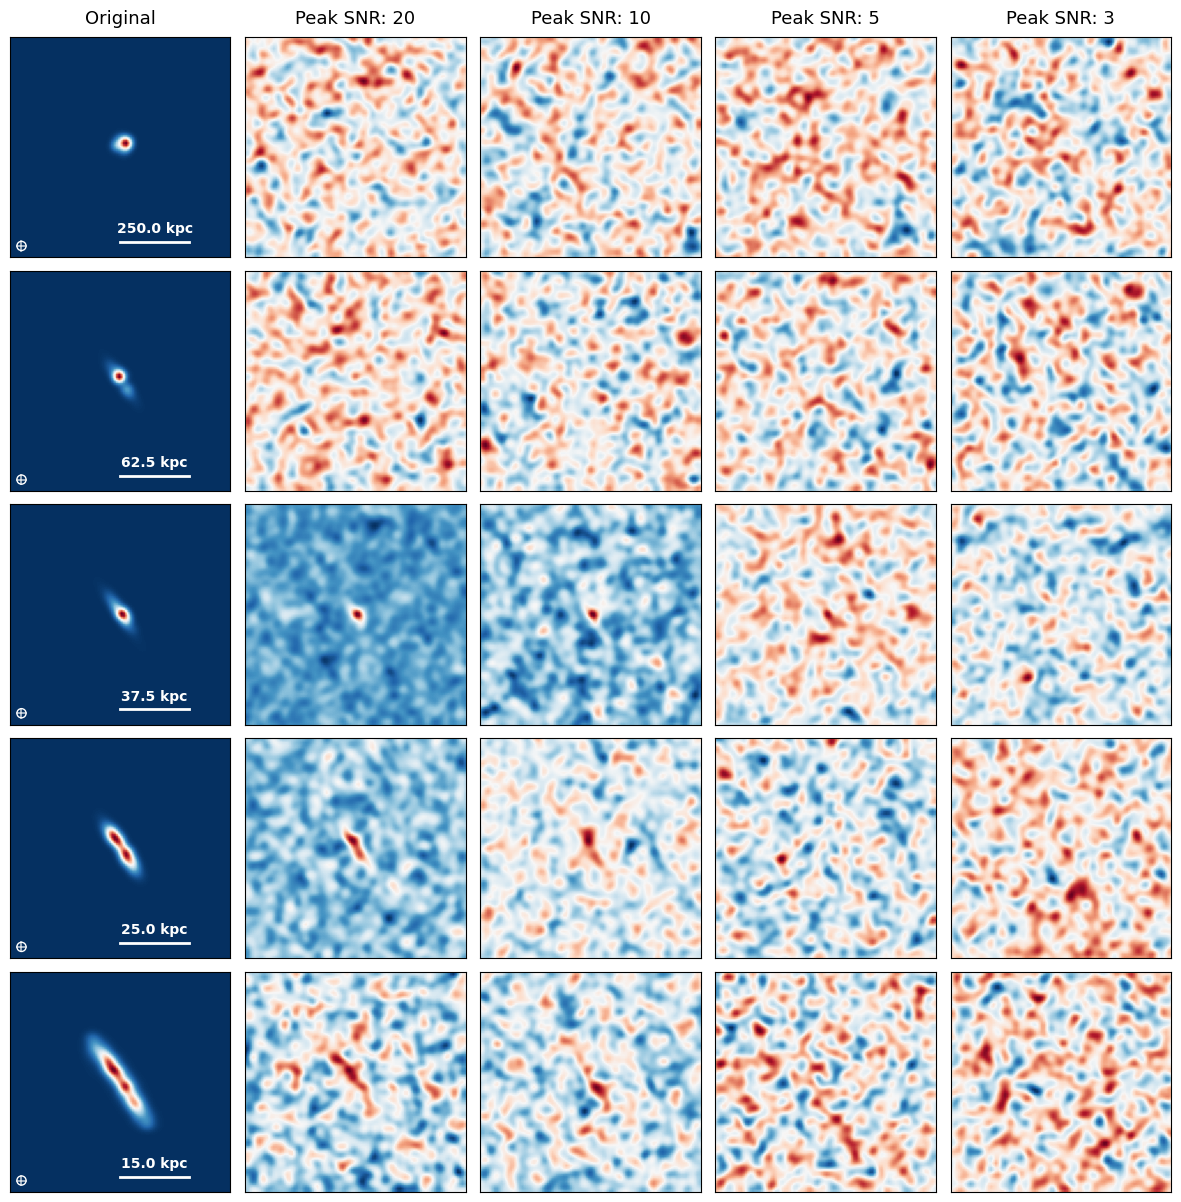

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import functions
import importlib
import toy_cube_dataset
importlib.reload(toy_cube_dataset)
importlib.reload(functions)
from functions import *
from toy_cube_dataset import *

ticks = np.linspace(0, 64, 5)
labels = ['{:.1f}'.format(i) for i in ticks]


case = 'visualise'
n_gals = 1
n_cubes = 5
init_grid_size = 41
final_grid_size = 96
n_spectral_slices = 40
offset_gals = 15
beam_size = 5
seed = np.random.randint(0, 10000)
print(seed)

resolved_dataset = ResolvedSpectralCubeDataset(n_gals = n_gals, resolution=case,offset_gals=offset_gals, beam_size=beam_size,
                                               n_cubes=n_cubes, init_grid_size= init_grid_size, final_grid_size=final_grid_size,
                                               n_spectral_slices=n_spectral_slices, verbose=False, plot=False, seed=seed)




def plot_beam_noise_grid(datasets, ratios, peak_snrs, cmap='RdBu_r'):
    n_rows = len(datasets)
    n_cols = len(peak_snrs)
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(3 * n_cols, 3 * n_rows)  # reduced padding
    )

    for row, datasets in enumerate(datasets):
        cube = datasets[0]
        pix_spatial_scale = datasets[1]['pix_spatial_scale']
        convolved_cube = convolve_beam(cube, beam_size)
        max_voxel_index = np.argmax(convolved_cube)
        max_channel, max_y, max_x = np.unravel_index(max_voxel_index, convolved_cube.shape)
        
        for col, peak_snr in enumerate(peak_snrs):

            noise_cube_beam = apply_and_convolve_noise(convolved_cube, peak_snr=peak_snr, beam_width_px=beam_size)
            #max_voxel_index = np.argmax(cube)
            #max_channel, max_y, max_x = np.unravel_index(max_voxel_index, cube.shape)


            ax = axes[row, col] if n_rows > 1 else axes[col]
            extent = [0, noise_cube_beam.shape[2], 0, noise_cube_beam.shape[1]]
            ax.imshow(noise_cube_beam[20].T, origin='lower', cmap=cmap, extent=extent)
            #ax.contour(mask.sum(axis=0), levels=[0.5], colors='white', linewidths=1, linestyles='dashed', extent=extent)

            # Remove ticks and labels
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])


            # Add beam ellipse only once per row
            if row == 0:
                if col == 0:
                    ax.set_title(f'Original', fontsize=13, pad=10)
                else:   ax.set_title(f'Peak SNR: {peak_snr}', fontsize=13, pad=10)
            if col == 0:
                add_beam(ax, beam_size, beam_size, 0, xy_offset=(5, 5), color='white', crosshair=True)
                

            # Add scalebars
            scalebar_length = 30 #kpc/pix_spatial_scale  # in kpc
            x_max = noise_cube_beam.shape[2]
            y_max = noise_cube_beam.shape[1]
            x0 = x_max * 0.5
            y0 = y_max * 0.07

            if col == 0:
                ax.plot([x0, x0 + scalebar_length], [y0, y0], color='white', lw=2)
                ax.text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{scalebar_length*pix_spatial_scale:.1f} kpc',
                        color='white', ha='center', va='bottom', fontsize=10, weight='bold')


                

               
        
            
    # Manually adjust spacing between plots
    plt.subplots_adjust(wspace=0.06, hspace=0.06)

    plt.savefig('toy_visualise.pdf', bbox_inches='tight')
    plt.show()



# Now use only 2 cubes
datasets = [resolved_dataset[i] for i in range(n_cubes)]

ratios = np.asarray([0.8,1.2,2,3,5])  # Update ratio list accordingly (only 2)
peak_snrs = [100000000, 20, 10, 5, 3]

plot_beam_noise_grid(datasets, ratios, peak_snrs)


4.0
1.5000000000000002
19.999999999999996


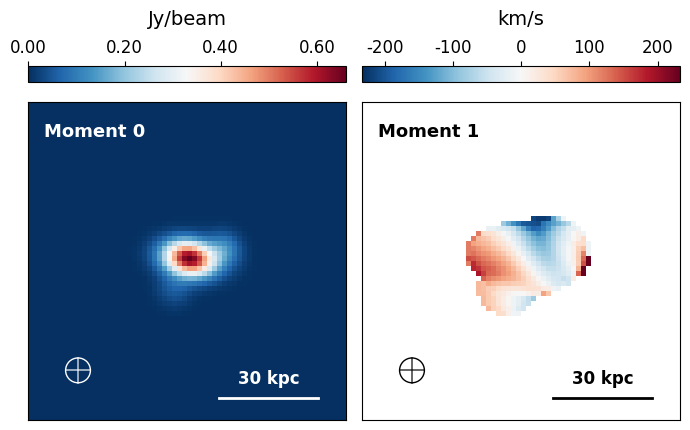

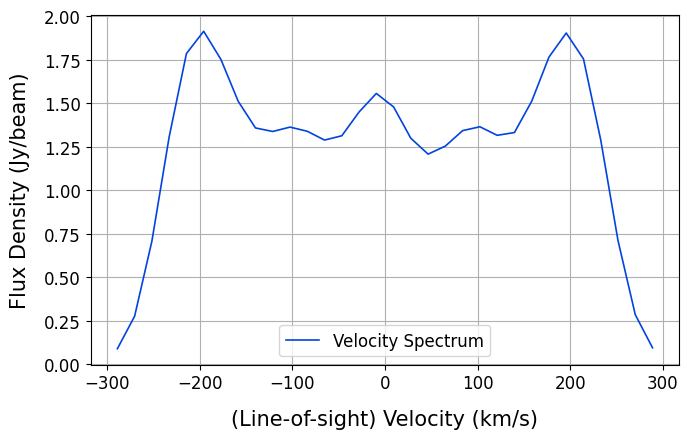

In [ ]:
case = 'resolved'

from astrodendro import Dendrogram
cube = resolved_dataset[0][0]
print(resolved_dataset[0][1]['redshift'])
convolved_cube = convolve_beam(cube,5)
vels = resolved_dataset[0][1]['average_vels']
pix_spatial_scale = resolved_dataset[0][1]['pix_spatial_scale']
moment_cube = convolved_cube * vels[:, np.newaxis, np.newaxis]  # Calculate the moment cube

print(pix_spatial_scale)

if case == 'resolved':
    kpc = 30
elif case == 'unresolved':
    kpc = 100

mask = np.zeros(convolved_cube.shape, dtype=bool)
d1 = Dendrogram.compute(convolved_cube, min_value=0.25 * convolved_cube.std(), min_delta=convolved_cube.std(), verbose=False)
for trunk in d1.trunk:
    mask |= trunk.get_mask()


import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get image shape and extent in kpc
ny, nx = cube.shape[1], cube.shape[2]
x_max = nx# * pix_spatial_scale
y_max = ny# * pix_spatial_scale
extent = [0, x_max, 0, y_max]  # (xmin, xmax, ymin, ymax)

# Define tick locations (in kpc)
num_ticks = 5
tick_locs = np.linspace(0, x_max, num_ticks)
tick_labels = [f"{tick:.1f}" for tick in tick_locs]

fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharex=True, sharey=True)

# Plot 1: moment 0 map
im0 = ax[0].imshow(convolved_cube.sum(axis=0), cmap='RdBu_r', origin='lower', extent=extent)
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("top", size="5%", pad=0.2)
cb0 = fig.colorbar(im0, cax=cax0, orientation='horizontal', label='Jy/beam', format='%.2f')
cb0.ax.xaxis.set_label_position('top')
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.label.set_size(14)
cb0.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb0.ax.xaxis.labelpad = 10
ax[0].text(x_max * 0.05, y_max * 0.89, 'Moment 0', color='white', fontsize=13, weight='bold')
add_beam(ax[0], 5, 5, 0, xy_offset=(10, 10), color='white')

# Plot 2: moment 1 map
numerator = (mask * moment_cube).sum(axis=0)
denominator = (mask * convolved_cube).sum(axis=0)
ratio = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator != 0)
max = np.max([np.abs(np.nanmin(ratio)), np.abs(np.nanmax(ratio))])
im1 = ax[1].imshow(ratio, cmap='RdBu_r', origin='lower', extent=extent, vmin=-max, vmax=max)
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("top", size="5%", pad=0.2)
cb1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', label='km/s', format='%.0f')
cb1.ax.xaxis.set_label_position('top')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb1.ax.xaxis.label.set_size(14)
cb1.ax.xaxis.labelpad = 10
ax[1].text(x_max * 0.05, y_max * 0.89, 'Moment 1', color='black', fontsize=13, weight='bold')
add_beam(ax[1], 5, 5, 0, xy_offset=(10, 10), color='black')

# Remove ticks and labels
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel('')
    a.set_ylabel('')

# Add scalebars
scalebar_length = kpc/pix_spatial_scale  # in kpc
print(scalebar_length)
x0 = x_max * 0.6
y0 = y_max * 0.07

# Scalebar for Moment 0
ax[0].plot([x0, x0 + scalebar_length], [y0, y0], color='white', lw=2)
ax[0].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, '30 kpc',
           color='white', ha='center', va='bottom', fontsize=12, weight='bold')

# Scalebar for Moment 1
ax[1].plot([x0, x0 + scalebar_length], [y0, y0], color='black', lw=2)
ax[1].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, '30 kpc',
           color='black', ha='center', va='bottom', fontsize=12, weight='bold')


for a in ax:
    a.set_aspect('equal')  # or 'auto' if stretching is preferred


plt.tight_layout()
plt.savefig('moment_maps_res.pdf', bbox_inches='tight')
plt.show()


plt.figure(figsize = (7, 4.5))
#plt.plot(vels, np.sum(convolved_cube, axis=(1,2)), color='xkcd:blue', label='Velocity Spectrum', linewidth=0.8, alpha=0.3)
from scipy.ndimage import gaussian_filter1d
y_smooth = gaussian_filter1d(np.sum(convolved_cube, axis=(1,2)), sigma=1.5)
plt.plot(vels, y_smooth, color='xkcd:blue', label='Velocity Spectrum', linewidth=1.2)
plt.ylabel('Flux Density (Jy/beam)', fontsize=15, labelpad = 10)
plt.xlabel('(Line-of-sight) Velocity (km/s)', fontsize=15, labelpad = 12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True)
plt.legend(fontsize = 12, loc='lower center')
plt.tight_layout()
plt.savefig('init_velocity_spectrum_res.pdf', bbox_inches='tight')
plt.show()



In [280]:
print(resolved_dataset[0][1]['pix_angular_scale'])
print(unresolved_dataset[0][1]['pix_angular_scale'])

0.1884952742997501
1.0925337173138088


In [ ]:
from functions import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches

for i in range(n_cubes):

    convolved_cube = final_dataset[i][1][0].detach().numpy()
    print(convolved_cube.shape)
    #convolved_cube = apply_and_convolve_noise(convolved_cube, 60, final_dataset[i][2][2].item())
    vels = (final_dataset[i][3].numpy())


    max_voxel_index = np.argmax(final_dataset[i][1][0].detach().numpy())  # Get flattened index
    max_channel, max_y, max_x = np.unravel_index(max_voxel_index, convolved_cube.shape)  # Convert to 3D index


    fig, ax = plt.subplots(1,2,figsize = (13,5))

    extent = [0, convolved_cube.shape[2], 0, convolved_cube.shape[1]]  # [x_min, x_max, y_min, y_max]

    im0 = ax[0].imshow(convolved_cube[max_channel], origin = 'lower', cmap = 'RdBu_r', extent=extent)
    #ax[0].contour(mask, levels=[0.5], colors='white', linewidths=2)
    fig.colorbar(im0, ax = ax[0])
    ticks = np.linspace(0, final_grid_size, 6)

    #labels = ['{:.2f}'.format(i) for i in ticks]
    labels = ['0', '12.80', '25.60', '38.40', '51.20', '64.00']
    ax[0].set_xticks(ticks)
    ax[0].set_yticks(ticks)
    ax[0].set_xlabel('Kpc', fontsize = 15, labelpad = 12)
    ax[0].set_xticklabels(labels, fontsize = 11)
    ax[0].set_yticklabels(labels, fontsize = 11)
    ax[0].set_ylabel('Kpc', fontsize = 15)


    corner_offset = 7
    beam_width_px = (0.4/0.06)

    beam_center = (corner_offset + beam_width_px / 2, corner_offset + beam_width_px / 2)

    # Create an ellipse patch
    beam_ellipse = patches.Ellipse(
        xy=beam_center, width=beam_width_px, height=beam_width_px, label='Beam',
        angle=0, edgecolor="white", facecolor="none", linestyle='-', linewidth=1
    )

    #ax[0].add_patch(beam_ellipse)

    '''ax[0].text(
        beam_center[0] + (2 * beam_width_px) / 1.5 + 10, 5.4, "Beam",
        color="white", fontsize=12, ha="center", va="bottom", bbox=dict(facecolor="black", alpha=0.0, edgecolor="none")
    )'''




    ax[1].plot(vels, np.sum(convolved_cube, axis = (1,2)), color = 'xkcd:blue', label = 'Velocity Spectrum')
    ax[1].set_ylabel('Flux Density (Jy/beam)', fontsize = 15, labelpad = 10)
    ax[1].set_xlabel('LOS Velocity (km/s)', fontsize = 15, labelpad = 12)
    ax[1].tick_params(axis='x', labelsize=13)
    ax[1].grid(True)

    plt.legend(fontsize = 13)

    plt.tight_layout()
    plt.savefig('toy_spectra.pdf', bbox_inches='tight')
    plt.show()

4104
[2. 2.] 3.75
[3.75 3.75]

[ § Creating 2 highly resolved cubes of dimensions 36 (spectral) x 72 x 72 (spatial) § ]

[0.5 0.5] 3.75
[0.9375 0.9375]

[ § Creating 2 highly resolved cubes of dimensions 36 (spectral) x 72 x 72 (spatial) § ]

Time taken: 1.6939940452575684 seconds
kpc 22.5 pix_scale 1.3333333333333333
22.5
22.5
kpc 20.625 pix_scale 5.333333333333333
20.625
20.625


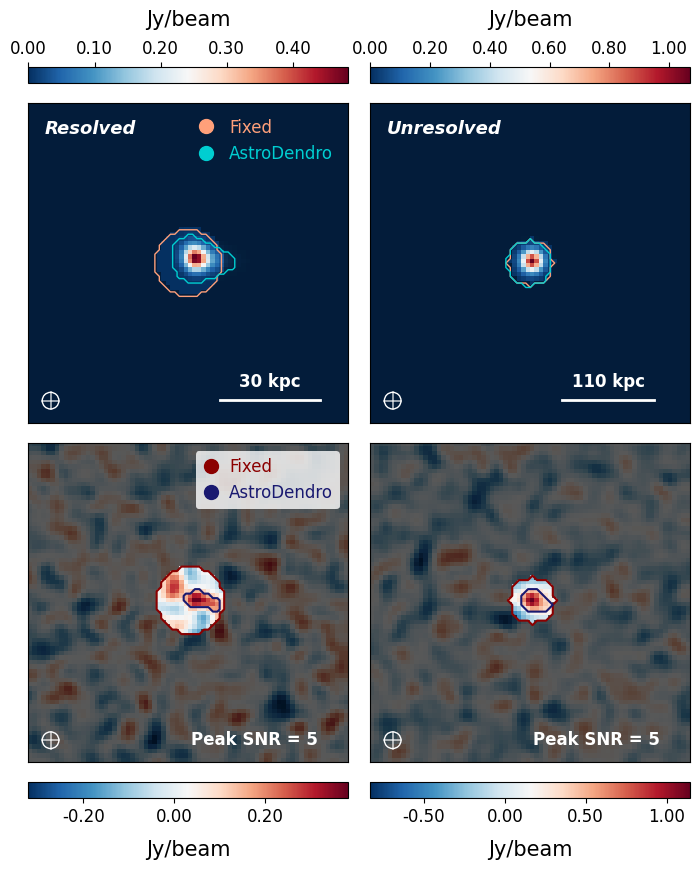

In [ ]:
from astrodendro import Dendrogram
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import functions
import importlib
importlib.reload(functions)
from functions import *



import toy_cube_dataset
import importlib
importlib.reload(toy_cube_dataset)
from toy_cube_dataset import *
import time

start = time.time()
n_gals = 1
offset_gals = 21
n_cubes = 2
init_grid_size= 31
final_grid_size=72
n_spectral_slices=36
beam_size = 5*(72/96)

#6453
seed = np.random.randint(0, 10000)
case1 = 'resolved'
case2 = 'unresolved'
print(seed)

fname = f'/Users/arnablahiry/Work/data/toy_cubes/datasets/'

resolved_dataset = ResolvedSpectralCubeDataset(n_gals = n_gals, resolution=case1,offset_gals=offset_gals, beam_size=beam_size,
                                               n_cubes=n_cubes, init_grid_size= init_grid_size, final_grid_size=final_grid_size,
                                               n_spectral_slices=n_spectral_slices, verbose=False, plot=False, seed=seed)

unresolved_dataset = ResolvedSpectralCubeDataset(n_gals = n_gals, resolution=case2,offset_gals=offset_gals, beam_size=beam_size,
                                               n_cubes=n_cubes, init_grid_size= init_grid_size, final_grid_size=final_grid_size,
                                               n_spectral_slices=n_spectral_slices, verbose=False, plot=False, seed=seed)


stop = time.time()
print(f'Time taken: {stop - start} seconds')    





n_rows = 2
n_cols = 2

datasets = [resolved_dataset, unresolved_dataset]
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7, 8.8))
axes = axes.flatten()
peak_snr = 3

idxes = [0,1]

plt.rcParams["text.usetex"] = False

case = ['Resolved','Unresolved']


for i, index in enumerate(idxes):  # Only 3 cubes

    peak_snr = 5

    convolved_cube = convolve_beam(datasets[i][0][0]*50, 5*(72/96))
    noisy_cube = apply_and_convolve_noise(convolved_cube, 5, beam_width_px=3.5) #final_dataset[index][0][0].detach().numpy()
    extent = [0, convolved_cube.shape[2], 0, convolved_cube.shape[1]]

    R_e = 5/datasets[i][0][1]['pix_spatial_scale']


    mask_circ, rad = create_circular_aperture_mask(convolved_cube, R_e, 5)  # e.g., 1% of total flux

    if i == 0:
        kpc=30
    elif i == 1:
        kpc=110
        
    px = kpc/datasets[i][0][1]['pix_spatial_scale']
    print('kpc', px, 'pix_scale', datasets[i][0][1]['pix_spatial_scale'])


    for j, display_cube in enumerate([convolved_cube, noisy_cube]):

       

        idx = i + j * 2  # top row: j=0 → idx=i, bottom row: j=1 → idx=i+3

        max_voxel_index = np.argmax(convolved_cube)
        max_channel, max_y, max_x = np.unravel_index(max_voxel_index, convolved_cube.shape)

        d = Dendrogram.compute(
            display_cube,
            min_value=(1 if j == 0 else 1.5) * display_cube.std(),
            min_delta=(2 if j == 0 else 2) * display_cube.std(),
            verbose=False
        )

        mask = np.zeros(display_cube.shape, dtype=bool)
        for trunk in d.trunk:
            mask |= trunk.get_mask()

        ax = axes[idx]
        im = ax.imshow(display_cube[max_channel], cmap='RdBu_r', origin = 'lower', extent=extent)
        overlay = np.zeros((*mask_circ[max_channel].shape, 4))  # RGBA image
        overlay[~mask_circ[max_channel]] = [0, 0, 0, 0.4]       # black with alpha 0.7
        ax.imshow(overlay, origin='lower', extent=extent)

        

        # Add scalebars
        scalebar_length = px  # in kpc
        print(scalebar_length)
        x_max = display_cube.shape[2]
        y_max = display_cube.shape[1]
        x0 = x_max * 0.6
        y0 = y_max * 0.07

        if j == 0:
            ax.plot([x0, x0 + scalebar_length], [y0, y0], color='white', lw=2)
            ax.text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{kpc} kpc',
            color='white', ha='center', va='bottom', fontsize=12, weight='bold')

        divider = make_axes_locatable(ax)

        if j == 0:
            # Clean cube → top row
            ax.contour(mask_circ[max_channel], levels=[0.5], colors='lightsalmon', linewidths=1)
            ax.contour(mask[max_channel], levels=[0.5], colors='darkturquoise', linewidths=1)

            corner_offset = 2
            beam_width_px = 0.2/0.06

            
            
            ax.text(0.05, 0.95, f'{case[i]}', transform=ax.transAxes, color='white', fontsize=13, weight = 'bold', style='italic',
                    ha='left', va='top', bbox=dict(facecolor='midnightblue', edgecolor='none',
                                                    boxstyle='round,pad=0.5', alpha=0.0))
            
            
            
            
            add_beam(ax, 5*(72/96), 5*(72/96), 0, xy_offset=(5, 5), color='white', crosshair=True)

            cax = divider.append_axes("top", size="5%", pad=0.2)
            cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
            cax.xaxis.set_ticks_position('top')
            cax.xaxis.set_label_position('top')

            if i == 0:
                legend_elements = [
                    Line2D([0], [0], marker='o', linestyle='None', color='none', label='Fixed',
                        markerfacecolor='lightsalmon', markeredgecolor='lightsalmon', markersize=10),
                    Line2D([0], [0], marker='o', linestyle='None', color='none', label='AstroDendro',
                        markerfacecolor='darkturquoise', markeredgecolor='darkturquoise', markersize=10)
                ]

                legend = ax.legend(handles=legend_elements,
                                loc='upper right',
                                fontsize=12,
                                frameon=True,
                                facecolor='none',     # transparent background
                                edgecolor='none',
                                handlelength=1.5,
                                handletextpad=0.6)

                # Set legend text colors to match the markers
                for text, color in zip(legend.get_texts(), ['lightsalmon', 'darkturquoise']):
                    text.set_color(color)
                

        else:
            # Noisy cube → bottom row
            ax.contour(mask_circ[max_channel], levels=[0.5], colors='darkred', linewidths=1.5, extent=extent)
            # 2. Overlay black where mask is False
            overlay = np.zeros((*mask_circ[max_channel].shape, 4))  # RGBA image
            overlay[~mask_circ[max_channel]] = [0, 0, 0, 0.4]       # black with alpha 0.7
            ax.imshow(overlay, origin='lower', extent=extent)

            ax.contour(mask[max_channel], levels=[0.5], colors='midnightblue', linewidths=1.5, extent=extent)


            add_beam(ax, 5*(72/96), 5*(72/96), 0, xy_offset=(5, 5), color='white', crosshair=True)

            ax.text(0.51, 0.1, f'Peak SNR = {peak_snr}', transform=ax.transAxes, color='white', fontsize=12, weight='bold',
                    ha='left', va='top', bbox=dict(facecolor='none', edgecolor='none',
                                                    boxstyle='round,pad=0.5', alpha=0.9))
            

            cax = divider.append_axes("bottom", size="5%", pad=0.2)
            cbar = fig.colorbar(im, cax=cax, orientation='horizontal')

            from matplotlib.lines import Line2D

            if i == 0:
                legend_elements = [
                    Line2D([0], [0], marker='o', linestyle='None', color='none',
                        markerfacecolor='darkred', markeredgecolor='darkred', markersize=10,
                        label='Fixed'),
                    Line2D([0], [0], marker='o', linestyle='None', color='none',
                        markerfacecolor='midnightblue', markeredgecolor='midnightblue', markersize=10,
                        label=r'AstroDendro')
                ]

                legend = ax.legend(handles=legend_elements,
                                loc='upper right',
                                fontsize=12,
                                frameon=True,
                                facecolor='white',   # transparent background
                                edgecolor='none',
                                handlelength=1.0,
                                handletextpad=0.6)

                # Set text colors to match marker colors
                for text, color in zip(legend.get_texts(), ['darkred', 'midnightblue']):
                    text.set_color(color)



        cbar.ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        cbar.set_label('Jy/beam', fontsize=15, labelpad=10)
        cbar.ax.tick_params(labelsize=12)

        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout(pad=0.5, w_pad=0.3, h_pad=0.3)
plt.savefig('emission_masks.pdf')
plt.show()


In [215]:
x_center, y_center = 96 // 2, 96 // 2

print(x_center, y_center)


48 48


[0.8 1.2 2.  3.  5. ] 3.75
[1.5   2.25  3.75  5.625 9.375]

[ § Creating 5 highly resolved cubes of dimensions 36 (spectral) x 72 x 72 (spatial) § ]

[ 0. 16. 32. 48. 64.]


/var/folders/bp/qbk6vrmx3vz8pnjkwdvk9_b40000gn/T/ipykernel_10590/764660346.py:118: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


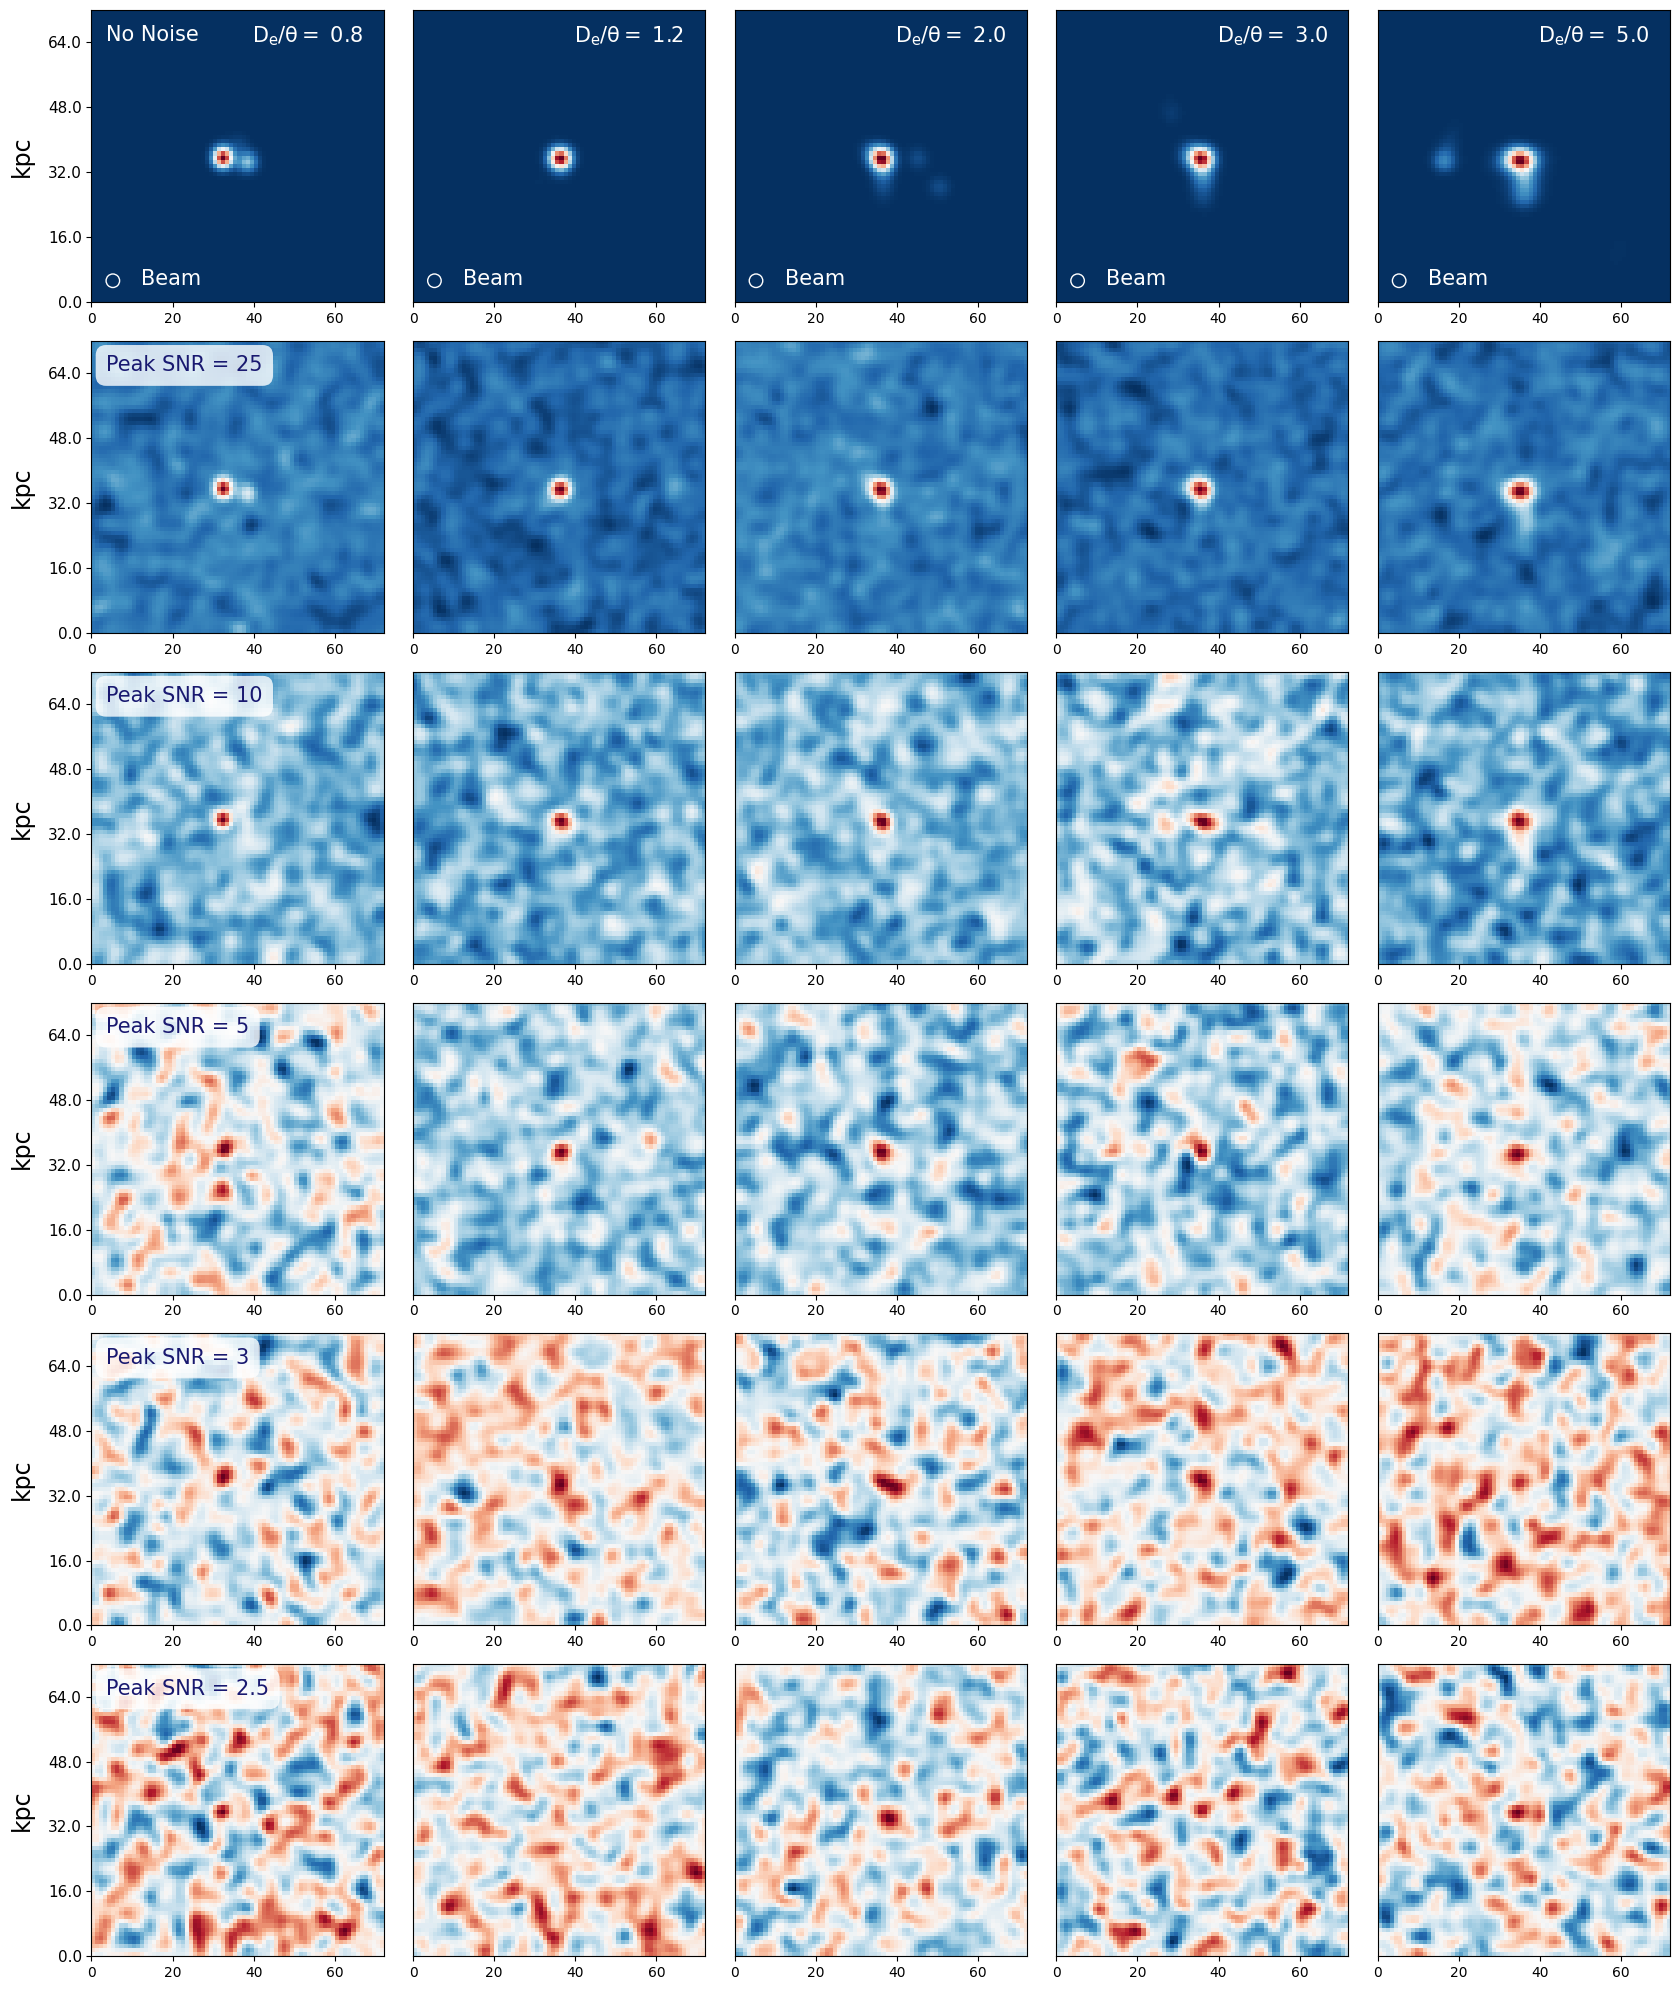

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import functions
import importlib
import toy_cube_dataset
importlib.reload(functions)
importlib.reload(toy_cube_dataset)
from functions import *
from toy_cube_dataset import *

case = 'visualise'
n_gals = 3
n_cubes = 5
init_grid_size = 31
final_grid_size = 72
n_spectral_slices = 36
offset_gals = 21
beam_size = 5 * (final_grid_size / 96)
seed = 666

resolved_dataset = ResolvedSpectralCubeDataset(n_gals = n_gals, resolution=case,offset_gals=offset_gals, beam_size=beam_size,
                                               n_cubes=n_cubes, init_grid_size= init_grid_size, final_grid_size=final_grid_size,
                                               n_spectral_slices=n_spectral_slices, verbose=False, plot=False, seed=seed)




ticks = np.linspace(0, 64, 5)
print(ticks)
labels = ['{:.1f}'.format(i) for i in ticks]


def plot_beam_noise_grid(cubes, ratios, peak_snrs, cmap='RdBu_r'):
    n_rows = len(peak_snrs)
    n_cols = len(cubes)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols+2, 3 * n_rows+2), constrained_layout=True)


    # Step 2: Plot with shared size axes
    for col,cube in enumerate(cubes):

        cube = convolve_beam(cube, 5*(72/96)) 

        for row, peak_snr in enumerate(peak_snrs):


            noise_cube_beam = apply_and_convolve_noise(cube, peak_snr=peak_snr, beam_width_px=5*(72/96))


            max_voxel_index = np.argmax(cube)
            max_channel, max_y, max_x = np.unravel_index(max_voxel_index, cube.shape)


            ax = axes[row, col] if n_rows > 1 else axes[col]

            extent = [0, noise_cube_beam.shape[2], 0, noise_cube_beam.shape[1]]
            im = ax.imshow(noise_cube_beam[max_channel].T, origin='lower', cmap='RdBu_r', extent = extent)#, vmin=vmin, vmax=vmax)

            # Set custom ticks and labels for x and y axes
            if col == 0:  # First column
                ax.set_yticks(ticks)
                ax.set_yticklabels(labels, fontsize=11)
                ax.set_ylabel('kpc', fontsize = 17, labelpad = 10)

            else:
                ax.set_yticks([])  # Remove y ticks for non-first columns

            #if row == len(peak_snrs) - 1:  # Last row
                #ax.set_xticks(ticks)
                #ax.set_xticklabels(labels)
                #ax.set_xlabel('kpc', fontsize = 17, labelpad = 10)
            #else:
                #ax.set_xticks([])  # Remove x ticks for non-last rows


            for spine in ax.spines.values():
                spine.set_visible(True)

            if row == 0:
                corner_offset=2

                if col==0:
                    ax.text((corner_offset + 5)/41, 0.115, f'Beam', transform=ax.transAxes, color='white', fontsize=15,
                            ha='left', va='top', bbox=dict(facecolor='midnightblue', edgecolor='none',
                                                        boxstyle='round,pad=0.5', alpha=0.0))
                else:
                    ax.text((corner_offset + 5)/41, 0.115, f'Beam', transform=ax.transAxes, color='white', fontsize=15,
                            ha='left', va='top', bbox=dict(facecolor='midnightblue', edgecolor='none',
                                                        boxstyle='round,pad=0.5', alpha=0.0))
                    
                
                ax.text(0.55, 0.95, r'$\mathrm{D_e/\theta}=$' +' {:.1f}'.format(ratios[col]), transform=ax.transAxes, color='white', fontsize=15,
                    ha='left', va='top', bbox=dict(facecolor='midnightblue', edgecolor='none',
                                                    boxstyle='round,pad=0.5', alpha=0.0))
                


                corner_offset = 3.6
                beam_width_px = 0.2/0.06
                beam_center = (corner_offset + beam_width_px / 2, corner_offset + beam_width_px / 2)

                beam_ellipse = patches.Ellipse(
                    xy=beam_center, width=beam_width_px, height=beam_width_px,
                    angle=0, edgecolor="white", facecolor="none", linestyle='-', linewidth=1
                )
                ax.add_patch(beam_ellipse)

            if col == 0:
                label = "No Noise" if row == 0 else f'Peak SNR = {peak_snr}'
                color = 'white' if row == 0 else 'midnightblue'
                bg = dict(facecolor='midnightblue' if row == 0 else 'white',
                          edgecolor='none', boxstyle='round,pad=0.5', alpha=0.8 if row > 0 else 0.0)
                ax.text(0.05, 0.95, label, transform=ax.transAxes, color=color,
                        fontsize=15, ha='left', va='top', bbox=bg)


    plt.tight_layout()

    plt.savefig('toy_visualise.pdf', bbox_inches='tight')
    plt.show()


cubes = [resolved_dataset[i][0] for i in range(n_cubes)]

ratios = np.asarray([0.8,1.2,2,3,5])
peak_snrs = [1000000, 25, 10, 5, 3, 2.5]     # example values
plot_beam_noise_grid(cubes, ratios, peak_snrs)


In [ ]:
print(final_dataset[1][1][0].shape)